<div style ="border: blue solid 5px; font-family: Agency FB;	"><center>
<a href="#" ></a> 
    <h1> <font color="blue">TOP-DOWN: Modèle Filière</font> </h1> 
<a href="#" ></a>     
</center>
</div>

Dans ce note-book, nous réalisons le modèle avec les données filière. 

La modélisation Top-down, va permettre l'estimation des émissions de GES à partir des données filière issues de la fusion des données ESANE et données Secten de Citepa.

<li color = 'blue'> Objectif: décrire au mieux les variables agrégées au niveau filière qui expliquent les émissions de gaz à effet de serre.

# 1. Préliminaire

In [1]:
## Importation des packages nécessaires
import os # package de definition de repertoire
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # pour les graphiques
import seaborn as sns # pour les graphiques

import statsmodels.api as sm # pour la regression lineaire

In [2]:
# Définition du repertoire de travail
os.chdir("D:/ENSAI/2A/Projet Statistique/projet-risque-de-transition/")  # Mettez ici le repertoire de vos bases

In [3]:
# Importation de la base Filière
base_filiere = pd.read_csv("bdd/esane/base_secteur_vf.csv")

## Description de la base

La base comporte 26 variables et 216 individus. Les 216 individus sont les informations des 18 branches d'activités sur 12 ans (de 2009 à 2020). 

In [4]:
base_filiere.shape
#base_filiere.SecteurDActivite_secteur.value_counts()

(216, 26)

In [5]:
# liste des variables de la base
base_filiere.columns

Index(['annee_secteur', 'NbEntrp_secteur', 'Activite_secteur',
       'SecteurDActivite_secteur', 'FraisPersonnel_secteur',
       'Salaries_tps_plein_secteur', 'CA_exportation_secteur',
       'CA_hors_taxe_secteur', 'EBE_secteur',
       'VA_et_autres_prdts_charges_secteur', 'ResultatNetComptable_secteur',
       'CapaciteAutofinancement_secteur', 'ResultatCourantAvantImpots_secteur',
       'InvestCorporelsBrutsHorsApports_secteur', 'secteur_secteur',
       'description_ape_secteur', 'CO2_secteur', 'CO2e_secteur', 'CH4_secteur',
       'N2O_secteur', 'HFC_secteur', 'PFC_secteur', 'SF6_secteur',
       'NF3_secteur', 'Gaz_fluores_secteur', 'eges_secteur'],
      dtype='object')

Nous allons diviser toutes variables par le nombre d'entreprises du secteur pour avoir une estimation de la moyenne par secteur. Ainsi, nous réaliserons la modélisation avec les moyennes. Le modèle de régression par exemple sera sous la forme: <p>
$\overline{Y}_{filiere} = \beta_0 + \beta_1 * \overline{X}_{1,filiere} + ... + \beta_p * \overline{X}_{p,filiere} + \epsilon_{filiere}$ <p>
L'objectif de cette modélisation est d'analyser le comportement du groupe (filière) et de le comparer avec celui des individus (entreprises).

In [6]:
## Liste des variables pour lesquelles on calcule la moyenne par secteur
liste_normalisee = ['FraisPersonnel_secteur',
       'Salaries_tps_plein_secteur', 'CA_exportation_secteur',
       'CA_hors_taxe_secteur', 'EBE_secteur',
       'VA_et_autres_prdts_charges_secteur', 'ResultatNetComptable_secteur',
       'CapaciteAutofinancement_secteur','Salaries_tps_plein_secteur', 'ResultatCourantAvantImpots_secteur',
       'InvestCorporelsBrutsHorsApports_secteur', 'CO2_secteur', 'CO2e_secteur', 'CH4_secteur',
       'N2O_secteur', 'HFC_secteur', 'PFC_secteur', 'SF6_secteur',
       'NF3_secteur', 'Gaz_fluores_secteur', 'eges_secteur']

# Calcul de la moyenne par secteur
for var in liste_normalisee:
    base_filiere[var] = base_filiere[var]/base_filiere['NbEntrp_secteur']

base_filiere.drop('NbEntrp_secteur', axis=1, inplace=True)

#### Voyons la distrubution selon la variable secteur

<AxesSubplot:xlabel='secteur_secteur', ylabel='eges_secteur'>

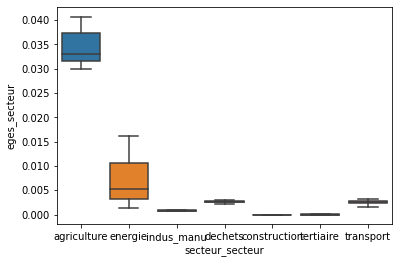

In [7]:
## Boxplot
sns.boxplot(x = "secteur_secteur", y = "eges_secteur", data=base_filiere, showfliers = False)

#### Creation des variables binaires sur les secteurs
On regroupe les filières selon leur ressemblance en terme de distribution d'émissions de GES.

In [8]:
# Création des secteurs
cond1 = (base_filiere["secteur_secteur"] == 'energie')
cond2 = (base_filiere["secteur_secteur"] == 'transport')
cond3 = ((base_filiere["secteur_secteur"] == 'agriculture') | (base_filiere["secteur_secteur"] == 'indus_manu'))
cond4 = ((base_filiere["secteur_secteur"] == 'tertiaire') | 
(base_filiere["secteur_secteur"] == 'dechets') |
(base_filiere["secteur_secteur"] == 'construction'))

print(sum(cond1))
print(sum(cond2))
print(sum(cond3))
print(sum(cond4))
base_filiere['energie_secteur'] = np.select([cond1, ~cond1], [1, 0])
base_filiere['transport_secteur'] = np.select([cond2, ~cond2], [1, 0])
base_filiere['agri_indusmanu_secteur'] = np.select([cond3, ~cond3], [1, 0])
base_filiere['autre_secteur'] = np.select([cond4, ~cond4], [1, 0])


base_filiere['secteur_nouveau'] = np.select([cond1, cond2,cond3,cond4],
["energie","transport", "agri_indusmanu", "autre_secteur"])


24
12
24
156


# 2. MODELISATION

## Sélection des variables par la méthode pas à pas

In [9]:
## Importation de package que nous avons implementé pour la sélection des variables
from selection_forward import forward_selected

### Suppression des variables qui n'interviennent pas dans le modèle.
Il s'agit des variables sur les différents types de GES (CO2, CH4, etc.) et les variables filière (`SecteurDActivite_secteur`) et secteur d'émissions (`secteur_secteur`).

In [10]:
liste_drop = ['Activite_secteur','SecteurDActivite_secteur','secteur_secteur',
       'description_ape_secteur', 'CO2_secteur', 'CO2e_secteur', 'CH4_secteur',
       'N2O_secteur', 'HFC_secteur', 'PFC_secteur', 'SF6_secteur',
       'NF3_secteur', 'Gaz_fluores_secteur',
       'secteur_nouveau']

base_filiere.drop(liste_drop, axis = 1, inplace = True)

In [11]:
print("AIC: ", forward_selected(base_filiere, 'eges_secteur', 'aic').model.formula)
print("BIC: ", forward_selected(base_filiere, 'eges_secteur', 'bic').model.formula)

AIC:  eges_secteur ~ 1 + agri_indusmanu_secteur+CapaciteAutofinancement_secteur+CA_exportation_secteur+CA_hors_taxe_secteur+autre_secteur+EBE_secteur+annee_secteur+FraisPersonnel_secteur+VA_et_autres_prdts_charges_secteur
BIC:  eges_secteur ~ 1 + agri_indusmanu_secteur+CapaciteAutofinancement_secteur+CA_exportation_secteur+CA_hors_taxe_secteur+autre_secteur


In [12]:
## Liste des variables explicatives
var_explicatives = ['agri_indusmanu_secteur','CapaciteAutofinancement_secteur',
'CA_exportation_secteur','CA_hors_taxe_secteur','energie_secteur','transport_secteur']


## Modèle explicatif

In [13]:
model1 = sm.OLS(base_filiere['eges_secteur'],
sm.add_constant(base_filiere[var_explicatives]),).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           eges_secteur   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     166.9
Date:                Sun, 01 May 2022   Prob (F-statistic):           7.58e-77
Time:                        23:32:51   Log-Likelihood:                 916.57
No. Observations:                 216   AIC:                            -1819.
Df Residuals:                     209   BIC:                            -1796.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.0013      0.000     -4.348      0.000      -0.002      -0.001
agri_indusmanu_secteur              0.0283      0.001     28.902      0.000       0.026       0.030
CapaciteAutofinancement_secteur     0.0004      0.000      0.746      0.457      -0.001       0.001
CA_exportation_secteur             -0.0239      0.001    -18.736      0.000      -0.026      -0.021
CA_hors_taxe_secteur                0.0041      0.000     17.955      0.000       0.004       0.005
energie_secteur                     0.0054      0.001      5.787      0.000       0.004       0.007
transport_secteur                   0.0055      0.001      5.119      0.000       0.003       0.008
==============================================================================
Omnibus:                      129.853   Durbin-Watson:                   1.683
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2943.123
Skew:                          -1.810   Prob(JB):                         0.00
Kurtosis:                      20.717   Cond. No.                         94.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Multicolinearite

In [14]:
## Testons la multicolinéarité
from statsmodels.stats.outliers_influence import variance_inflation_factor 

def vif(base, var_explicatives):

    vif_data = pd.DataFrame() 
    vif_data["feature"] = base[var_explicatives].iloc[:, 1:].columns 
    vif_data["VIF"] = [variance_inflation_factor(base[var_explicatives].iloc[:, 1:].values, i) 
        for i in range(len(base[var_explicatives].iloc[:, 1:].columns))] 
    vif_data.sort_values(by = 'VIF', ascending=False)
    return vif_data

In [15]:
## Testons la multicolinéarité
vif(base_filiere, var_explicatives)

,feature,VIF
0,CapaciteAutofinancement_secteur,9.465427
1,CA_exportation_secteur,108.205088
2,CA_hors_taxe_secteur,128.347113
3,energie_secteur,1.536557
4,transport_secteur,1.006821


In [16]:
var = ['agri_indusmanu_secteur','CapaciteAutofinancement_secteur',
'CA_exportation_secteur','CA_hors_taxe_secteur',
'energie_secteur','transport_secteur','EBE_secteur','annee_secteur',
'FraisPersonnel_secteur','Salaries_tps_plein_secteur',
'VA_et_autres_prdts_charges_secteur']

var = ['InvestCorporelsBrutsHorsApports_secteur',
'CapaciteAutofinancement_secteur', 'CA_exportation_secteur',
'energie_secteur', 'transport_secteur']

vif(base_filiere, var)

,feature,VIF
0,CapaciteAutofinancement_secteur,7.598355
1,CA_exportation_secteur,6.412954
2,energie_secteur,1.507616
3,transport_secteur,1.002417


## Modèle prédictif

In [17]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, cross_validate, cross_val_predict

from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, cross_validate, cross_val_predict
from regressors import stats
# Metric d'evaluation
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

C:\Users\amado\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\amado\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True,

In [18]:
base_filiere.columns

Index(['annee_secteur', 'FraisPersonnel_secteur', 'Salaries_tps_plein_secteur',
       'CA_exportation_secteur', 'CA_hors_taxe_secteur', 'EBE_secteur',
       'VA_et_autres_prdts_charges_secteur', 'ResultatNetComptable_secteur',
       'CapaciteAutofinancement_secteur', 'ResultatCourantAvantImpots_secteur',
       'InvestCorporelsBrutsHorsApports_secteur', 'eges_secteur',
       'energie_secteur', 'transport_secteur', 'agri_indusmanu_secteur',
       'autre_secteur'],
      dtype='object')

#### Suppression des variables non fortement corrélées à la variable cible, d'après la sélection AIC et l'analyse de la multicolinéarité.

In [19]:
list_drop = ['ResultatNetComptable_secteur',
       'CapaciteAutofinancement_secteur', 'ResultatCourantAvantImpots_secteur',
       'InvestCorporelsBrutsHorsApports_secteur']
    
base_filiere.drop(list_drop, axis=1, inplace=True)

### Conversion

In [20]:
# On convertit de Million en unité
for var in ['FraisPersonnel_secteur', 'Salaries_tps_plein_secteur',
       'CA_exportation_secteur', 'CA_hors_taxe_secteur', 'EBE_secteur',
       'VA_et_autres_prdts_charges_secteur', 'eges_secteur']:
       base_filiere[var] = base_filiere[var]*1000000

In [21]:
# enregistrement de la base.
base_filiere.to_csv("bdd/Base_finale/base_topdown.csv", index= False)

In [22]:
# Division de la base en apprentissage et test
x_train, x_test, y_train, y_test = train_test_split(base_filiere.drop('eges_secteur', axis=1),
base_filiere['eges_secteur'], test_size = 0.2, random_state = 2022)

In [23]:
modele_ridge = Ridge()
param ={'alpha':[0.0001,0.001,0.01,0.1,1.0,1.01,1.1,1.5,2,3,5,10]}
rigde_g = GridSearchCV(modele_ridge, param, cv=5, scoring='neg_mean_squared_error')


In [24]:
rigde_g.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 1.01, 1.1,
                                   1.5, 2, 3, 5, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [25]:
rigde_g.best_params_

{'alpha': 0.0001}

#### fonction d'évaluation

In [26]:
### courbe d'apprentissage
def evaluation(model, titre):
    print('+===================================================+')
    print(titre)
    y_pred = model.predict(x_test)
    plt.figure()
    plt.scatter(y_test, y_pred)
    plt.plot([np.min(y_test), np.max(y_test), 0.002], [np.min(y_test), np.max(y_test), 0.002], 'r-', lw=1)
    
    print("MSE: ", mean_squared_error(y_test, y_pred))
    
    N, train_score, val_score = learning_curve(model, x_train, y_train, cv=4, 
    scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1,1,5))
    plt.figure()
    plt.title(titre, size=16)
    plt.plot(N, train_score.mean(axis =1), label = 'train')
    plt.plot(N, val_score.mean(axis =1), label = 'validation')
    plt.legend()

## Modèle d'arbre de régression et Random Forest

In [27]:
dtr = DecisionTreeRegressor(max_depth = 3,
random_state=1, splitter='best')

param = {'max_depth':[3,4,5,6]}
rfr = RandomForestRegressor()

dtr.fit(x_train, y_train)
rfr.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [28]:
x_train.columns

Index(['annee_secteur', 'FraisPersonnel_secteur', 'Salaries_tps_plein_secteur',
       'CA_exportation_secteur', 'CA_hors_taxe_secteur', 'EBE_secteur',
       'VA_et_autres_prdts_charges_secteur', 'energie_secteur',
       'transport_secteur', 'agri_indusmanu_secteur', 'autre_secteur'],
      dtype='object')

In [29]:
liste_variable = ['annee_secteur','FraisPersonnel_secteur', 'Salaries_tps_plein_secteur',
       'CA_exportation_secteur', 'CA_hors_taxe_secteur', 'EBE_secteur',
       'VA_et_autres_prdts_charges_secteur']
liste_variable = ['Année', 'Frais Personnel', 'Salariés en temps plein',
       'CA à l\'exportation', 'CA hors taxe', 'EBE',
       'VA et autres prdts_charges', 'Energie',
       'Transport', 'Agriculture et Industrie manufacturière', 'Autre Filière']

liste_cat = ['energie_secteur',
       'transport_secteur', 'agri_indusmanu_secteur', 'autre_secteur']

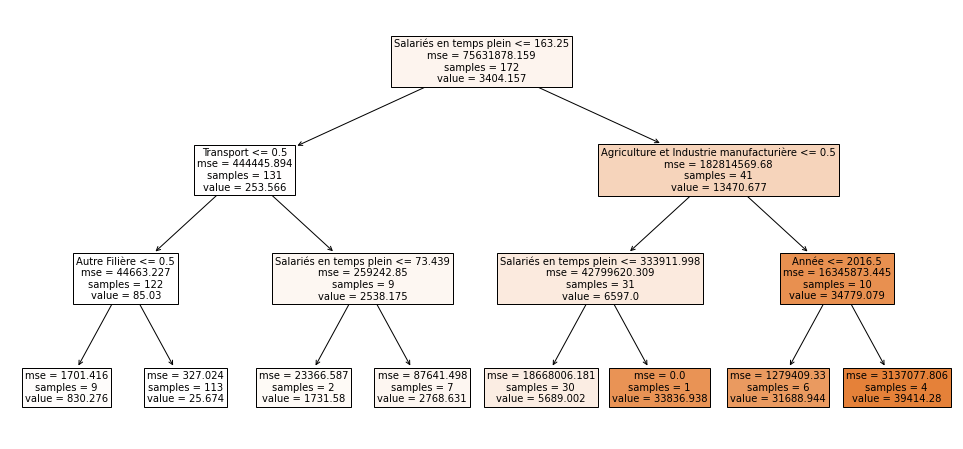

In [30]:
%matplotlib inline
plt.figure(figsize=(17,8))
plot_tree(dtr, filled=True, feature_names = liste_variable,fontsize=10, class_names= liste_cat)

plt.savefig("bdd/0image/arbre_modele_ratio.png")
plt.show()

+===================================================+
Régression rigde
MSE:  29764502.11776767


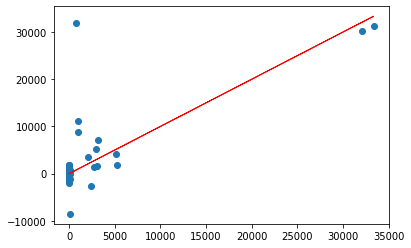

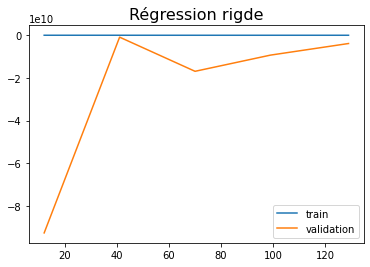

In [31]:
evaluation(rigde_g, 'Régression rigde')

+===================================================+
Arbre de régression
MSE:  649634.0406537014


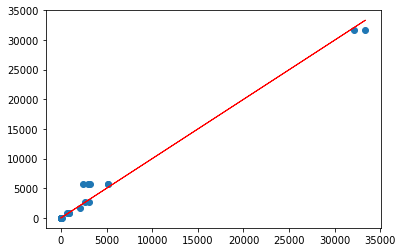

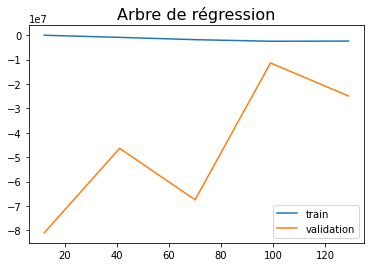

In [32]:
evaluation(dtr, 'Arbre de régression')

+===================================================+
Random Forest
MSE:  658062.1771675312


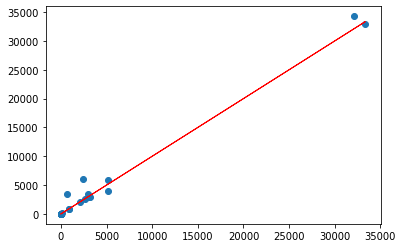

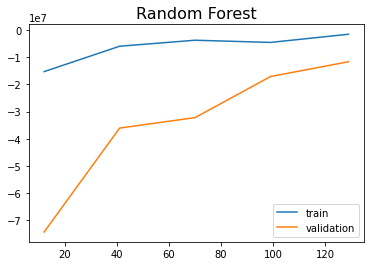

In [33]:
evaluation(rfr, 'Random Forest')